In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
!pip install -q segmentation-models-pytorch albumentations torchmetrics

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as album
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from pathlib import Path
import torch.backends.cudnn as cudnn
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import iou_score
from segmentation_models_pytorch import utils as smp_utils
from segmentation_models_pytorch.utils import metrics as smp_metrics

In [5]:
# Enable faster training with cuDNN optimization
cudnn.benchmark = True

# Set device: 'cuda' if available, else 'cpu'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read the data

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.79G/3.79G [02:55<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/deepglobe-road-extraction-dataset/versions/2


In [8]:
# Set dataset directory
DATA_DIR = Path('/root/.cache/kagglehub/datasets/balraj98/deepglobe-road-extraction-dataset/versions/2')

# Load metadata
metadata_df = pd.read_csv(DATA_DIR / 'metadata.csv')
metadata_df = metadata_df[metadata_df['split'] == 'train'][['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda x: DATA_DIR / x)
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda x: DATA_DIR / x)

# Shuffle data and split into train/valid sets
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)
valid_df = metadata_df.sample(frac=0.15, random_state=42)
train_df = metadata_df.drop(valid_df.index)

In [9]:
# Load class dictionary
class_dict = pd.read_csv(DATA_DIR / 'class_dict.csv')
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

# Select classes
select_classes = ['background', 'road']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [10]:
# Function to visualize images
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=16)
        plt.imshow(image)
    plt.show()

In [11]:
# One-hot encoding function
def one_hot_encode(label, label_values):
    """Returns binary mask for road class (shape: H,W,1)"""
    road_rgb = label_values[1]  # Get road RGB value
    road_mask = (label == road_rgb).all(axis=-1)  # Binary road mask
    return np.expand_dims(road_mask, axis=-1).astype(np.float32)  # Add channel dim

# Reverse one-hot encoding
def reverse_one_hot(one_hot_mask):
    """Converts (1,H,W) output to (H,W) binary mask"""
    if isinstance(one_hot_mask, torch.Tensor):
        one_hot_mask = one_hot_mask.cpu().numpy()
    return (one_hot_mask.squeeze() > 0.5).astype(np.uint8)  # Threshold at 0.5

def colour_code_segmentation(image, label_values):
    """Color code binary mask"""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    return np.where(image[..., None], label_values[1], label_values[0])

# Pad and resize image

In [12]:
# Optimized Dataset Class
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset

# Change max_size here to resize the image
# pad_image function ensure that all images feed to the model have the same size
def pad_image(image, max_stride=32, max_size=512):
    h, w = image.shape[:2]

    # Align max_size to stride if needed
    if max_size % max_stride != 0:
        max_size = ((max_size + max_stride - 1) // max_stride) * max_stride

    # Resize if larger than max_size
    if h > max_size or w > max_size:
        scale = min(max_size / h, max_size / w)
        new_w, new_h = int(w * scale), int(h * scale)
        image = cv2.resize(image, (new_w, new_h))
        h, w = image.shape[:2]

    # Pad to exactly max_size (which is stride aligned)
    pad_bottom = max_size - h
    pad_right = max_size - w

    return cv2.copyMakeBorder(image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=0)

class RoadsDataset(Dataset):
    def __init__(self, df, class_rgb_values, augmentation=None, preprocessing=None):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Load image and mask
        image = cv2.imread(str(self.image_paths[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[i]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Pad images
        image = pad_image(image)
        mask = pad_image(mask)

        # Create binary road mask (H,W,1)
        mask = one_hot_encode(mask, self.class_rgb_values)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Convert to tensor (C,H,W)
        image = torch.from_numpy(image).float().permute(2, 0, 1)
        mask = torch.from_numpy(mask).float().permute(2, 0, 1)

        return image, mask

    def __len__(self):
        return len(self.image_paths)

# Data Augmentation

In [13]:
# Data augmentation
def get_training_augmentation():
    return album.Compose([
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomBrightnessContrast(p=0.2),
        album.Rotate(limit=30, p=0.5),
        album.GaussNoise(std_range = (0.1, 0.2), p=0.2)
    ])

# Convert image to tensor
def to_tensor(x, **kwargs):
    return x.astype('float32')

# Preprocessing function
def get_preprocessing(preprocessing_fn=None):
    transforms = []
    if preprocessing_fn:
        transforms.append(album.Lambda(image=preprocessing_fn))
    transforms.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(transforms)

Fixed Sample image shape: torch.Size([3, 512, 512])
Fixed Sample mask shape: torch.Size([1, 512, 512])


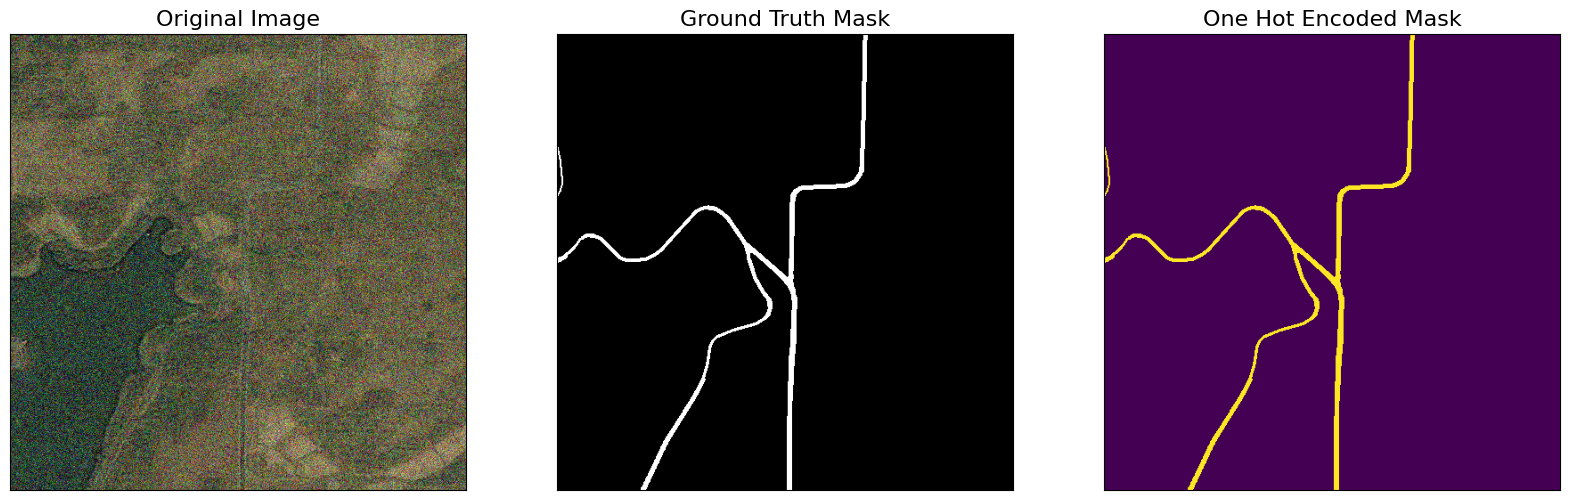

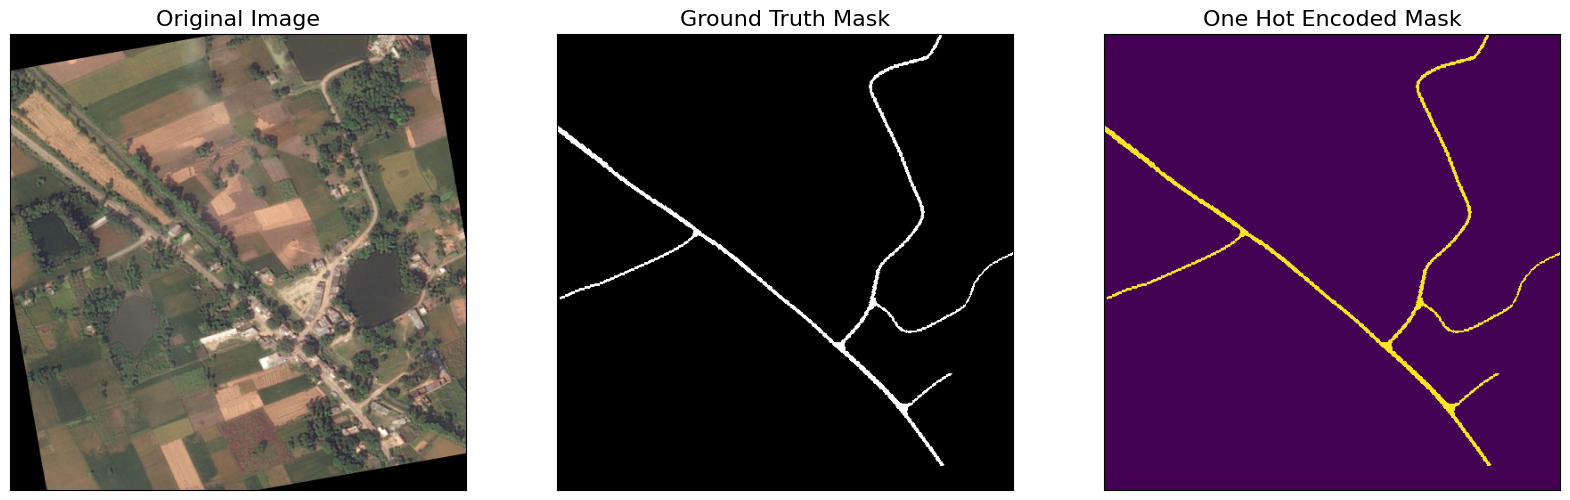

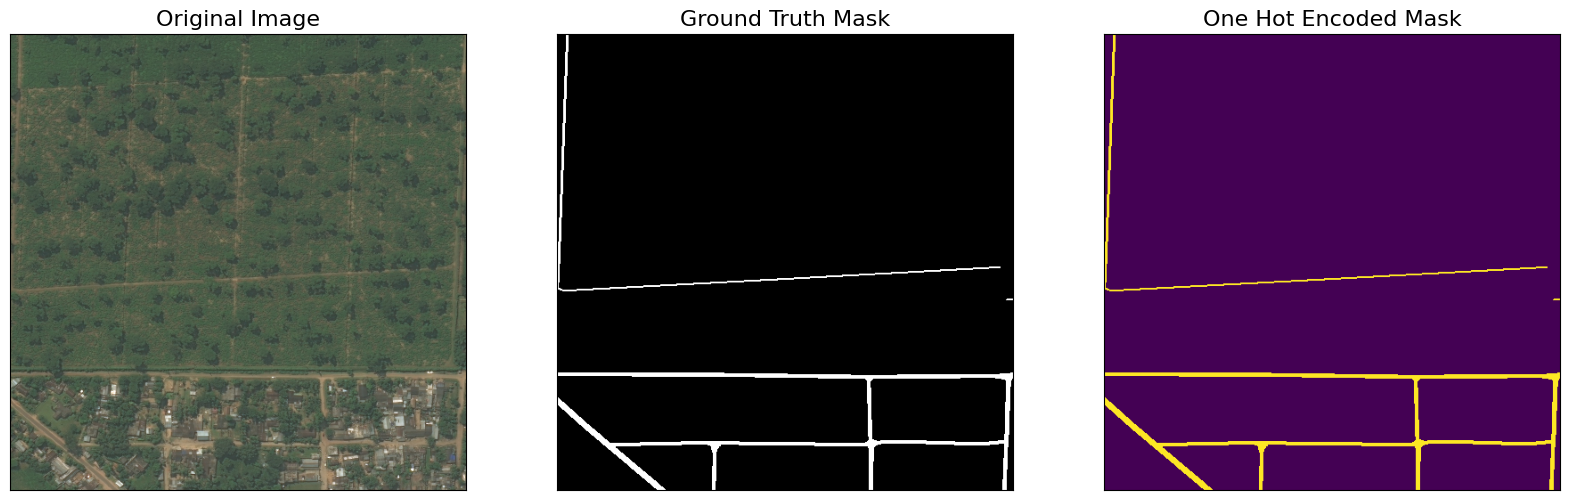

In [15]:
# Visualize Sample Image and Mask
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values, augmentation = get_training_augmentation())

sample_img, sample_mask = dataset[0]
print(f"Fixed Sample image shape: {sample_img.shape}")
print(f"Fixed Sample mask shape: {sample_mask.shape}")

for i in range(3):
    random_idx = random.randint(0, len(dataset)-1)

    # Get sample
    image_tensor, mask = dataset[random_idx]

    # Convert image back to HWC numpy array
    image_np = image_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC

    # Since your dataset has no normalization, values should be 0-255, but are still float32
    if image_np.dtype == np.float32:
        image_np = image_np.astype(np.uint8)  # Convert to uint8 (0-255)

    # Process mask
    mask_indices = reverse_one_hot(mask)
    colored_mask = colour_code_segmentation(mask_indices, select_class_rgb_values)

    # Visualize
    visualize(
        original_image=image_np,
        ground_truth_mask=colored_mask,
        one_hot_encoded_mask=mask_indices
    )

# Define model, encoder, weight, preprocessing function

In [16]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn, VGG16_BN_Weights

class SegNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=3):
        super(SegNet, self).__init__()

        vgg = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
        features = list(vgg.features.children())

        # Encoder blocks
        self.enc1 = nn.Sequential(*features[0:6])    # conv1_1 -> relu1_2 + maxpool1 (index 6 excluded)
        self.enc2 = nn.Sequential(*features[6:13])   # conv2_1 -> relu2_2 + maxpool2
        self.enc3 = nn.Sequential(*features[13:23])  # conv3_1 -> relu3_3 + maxpool3
        self.enc4 = nn.Sequential(*features[23:33])  # conv4_1 -> relu4_3 + maxpool4
        self.enc5 = nn.Sequential(*features[33:43])  # conv5_1 -> relu5_3 (no maxpool here)

        # Add the missing 5th maxpool after enc5
        self.maxpool5 = features[43]  # This is MaxPool2d(kernel_size=2, stride=2)

        # Decoder blocks
        self.dec5 = self._decoder_block(512, 512)
        self.dec4 = self._decoder_block(512, 256)
        self.dec3 = self._decoder_block(256, 128)
        self.dec2 = self._decoder_block(128, 64)
        self.dec1 = self._decoder_block(64, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.activation = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        x1 = self.enc1(x)
        # print(f"enc1 output shape: {x1.shape}")
        x2 = self.enc2(x1)
        # print(f"enc2 output shape: {x2.shape}")
        x3 = self.enc3(x2)
        # print(f"enc3 output shape: {x3.shape}")
        x4 = self.enc4(x3)
        # print(f"enc4 output shape: {x4.shape}")
        x5 = self.enc5(x4)
        # print(f"enc5 output shape (before maxpool5): {x5.shape}")
        x5 = self.maxpool5(x5)
        # print(f"enc5 output shape (after maxpool5): {x5.shape}")

        d5 = self.dec5(x5)
        d4 = self.dec4(d5)
        d3 = self.dec3(d4)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)

        out = self.final_conv(d1)
        return self.activation(out)


In [17]:
# Configuration
ENCODER = 'vgg16'  # Now works with VGG
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# Initialize model
model = SegNet(num_classes=1, in_channels=3).to(DEVICE)

# Get SMP preprocessing
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:04<00:00, 118MB/s] 
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [18]:
from segmentation_models_pytorch.encoders import get_preprocessing_params

# Get normalization parameters
preprocessing_params = get_preprocessing_params(ENCODER, ENCODER_WEIGHTS)
print("Mean:", preprocessing_params['mean'])
print("Std:", preprocessing_params['std'])

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


# Data preprocessing

In [19]:
# Create datasets and dataloaders
train_dataset = RoadsDataset(train_df, select_class_rgb_values, augmentation = get_training_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))
valid_dataset = RoadsDataset(valid_df, select_class_rgb_values, augmentation = None, preprocessing = get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
sample_img, sample_mask = train_dataset[0]
print(f"Fixed train image shape: {sample_img.shape}")
print(f"Fixed train mask shape: {sample_mask.shape}")

Fixed train image shape: torch.Size([3, 512, 512])
Fixed train mask shape: torch.Size([1, 512, 512])


In [21]:
sample_img, sample_mask = valid_dataset[0]
print(f"Fixed valid image shape: {sample_img.shape}")
print(f"Fixed valid mask shape: {sample_mask.shape}")

Fixed valid image shape: torch.Size([3, 512, 512])
Fixed valid mask shape: torch.Size([1, 512, 512])


# Training loss, metrics and learning rate scheduler

In [24]:
# Define loss function, optimizer, and metrics
loss = smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5)]

# Change learning rate here
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=0.6,
                                                       patience=2,
                                                       min_lr=1e-6,
                                                       threshold=0.001,
                                                       cooldown=1)

patience = 6
patience_counter = 0

In [25]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [26]:
dummy_input = torch.randn(1, 3, 512, 512).to(DEVICE)
dummy_output = model(dummy_input)
print(f"Dummy output shape: {dummy_output.shape}")

Dummy output shape: torch.Size([1, 1, 512, 512])


In [29]:
# !pip install wandb -q

In [30]:
# import wandb
# wandb.login(key="b94608572f4b7a61fd3bcc5958610e84e38e42e1")

# wandb.init(project="road_segmentation", name="Segnet_vgg16_01")

In [27]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# Training loop

In [32]:
# Training setup
EPOCHS = 20
best_iou_score = 0.0  # Start with 0 since we're looking to maximize this

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

# Initialize lists to store metrics
epoch_list = []
train_loss_list = []
valid_loss_list = []
train_iou_list = []
valid_iou_list = []
train_fscore_list = []
valid_fscore_list = []


# Training Loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    start_time = time.time()

    # Final phase
    # For second run
    if epoch == EPOCHS - 10:
        scheduler.factor = 0.8
        print("\nEntering final phase: gentler LR reductions")

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Store metrics
    epoch_list.append(epoch + 1)
    train_loss_list.append(train_logs['dice_loss + bce_loss'])
    valid_loss_list.append(valid_logs['dice_loss + bce_loss'])
    train_iou_list.append(train_logs['iou_score'])
    valid_iou_list.append(valid_logs['iou_score'])
    train_fscore_list.append(train_logs['fscore'])
    valid_fscore_list.append(valid_logs['fscore'])


    # Learning rate scheduling
    scheduler.step(valid_logs['iou_score'])

    # Model checkpointing
    current_iou = valid_logs['iou_score']
    if current_iou > best_iou_score:
        best_iou_score = current_iou
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
        print(f"New best IoU: {best_iou_score:.4f}")
    else:
        patience_counter += 1
        # Only count as bad epoch if IoU drops >0.2%
        if (best_iou_score - current_iou) > 0.002:
            print(f"⏳ Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("🛑 Early stopping triggered")
                break

    # Clean up
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Epoch completed in {time.time() - start_time:.2f} seconds")


Epoch 1/20
train:   0%|          | 0/1323 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: 100%|██████████| 234/234 [00:50<00:00,  4.68it/s, dice_loss + bce_loss - 0.5163, iou_score - 0.4502, fscore - 0.6151]
New best IoU: 0.4502
Epoch completed in 687.97 seconds

Epoch 2/20
valid: 100%|██████████| 234/234 [00:46<00:00,  5.00it/s, dice_loss + bce_loss - 0.4514, iou_score - 0.4942, fscore - 0.6582]
New best IoU: 0.4942
Epoch completed in 684.07 seconds

Epoch 3/20
valid: 100%|██████████| 234/234 [00:47<00:00,  4.93it/s, dice_loss + bce_loss - 0.4253, iou_score - 0.5156, fscore - 0.6772]
New best IoU: 0.5156
Epoch completed in 685.46 seconds

Epoch 4/20
valid: 100%|██████████| 234/234 [00:46<00:00,  5.00it/s, dice_loss + bce_loss - 0.4221, iou_score - 0.5158, fscore - 0.6774]
New best IoU: 0.5158
Epoch completed in 684.48 seconds

Epoch 5/20
valid: 100%|██████████| 234/234 [00:47<00:00,  4.97it/s, dice_loss + bce_loss - 0.4182, iou_score - 0.5205, fscore - 0.6812]
New best IoU: 0.5205
Epoch completed in 685.12 seconds

Epoch 6/20
valid: 100%|██████████| 234/234 [00:47<0

In [38]:
from google.colab import files

files.download('/content/best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [33]:
# Model evaluation
best_model = SegNet(num_classes=1, in_channels=3)
best_model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
best_model.to(DEVICE)
best_model.eval()

with torch.no_grad():
    test_epoch = smp.utils.train.ValidEpoch(
        best_model, loss=loss, metrics=metrics, device=DEVICE, verbose=True
    )
    valid_logs = test_epoch.run(valid_loader)

# Print evaluation results
print("\nEvaluation Results:")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['fscore']:.4f}")

valid:   0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: 100%|██████████| 234/234 [00:46<00:00,  4.99it/s, dice_loss + bce_loss - 0.3519, iou_score - 0.5813, fscore - 0.7323]

Evaluation Results:
Mean IoU Score: 0.5813
Mean Dice Loss: 0.7323


# Visualize prediction on satelite images (w/ no ground truth)

In [34]:
def denormalize_image(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    De-normalizes a tensor that was normalized using ImageNet statistics.
    Args:
        image_tensor (torch.Tensor): Tensor of shape (C, H, W), values in [0, 1] normalized.
        mean (list): Channel-wise mean used during normalization.
        std (list): Channel-wise std used during normalization.
    Returns:
        np.ndarray: De-normalized image in uint8 format, shape (H, W, C)
    """
    image = image_tensor.clone().cpu().numpy()
    for c in range(3):  # Assuming 3 channels (RGB)
        image[c] = image[c] * std[c] + mean[c]
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

Image # 0


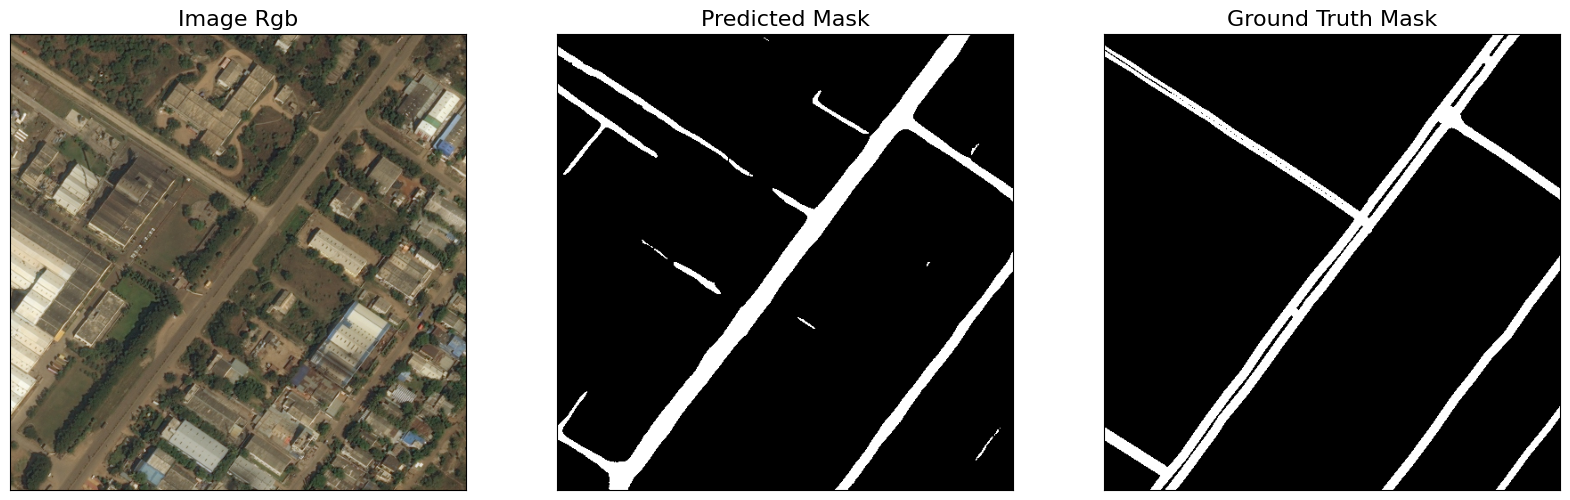

Image # 1


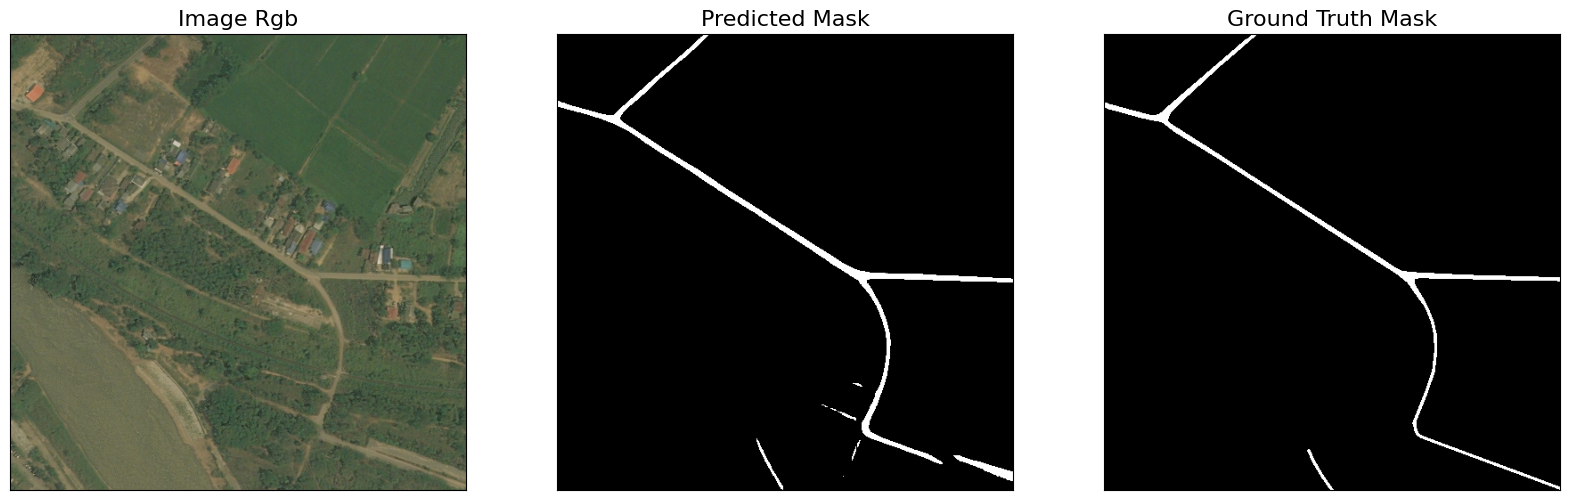

Image # 2


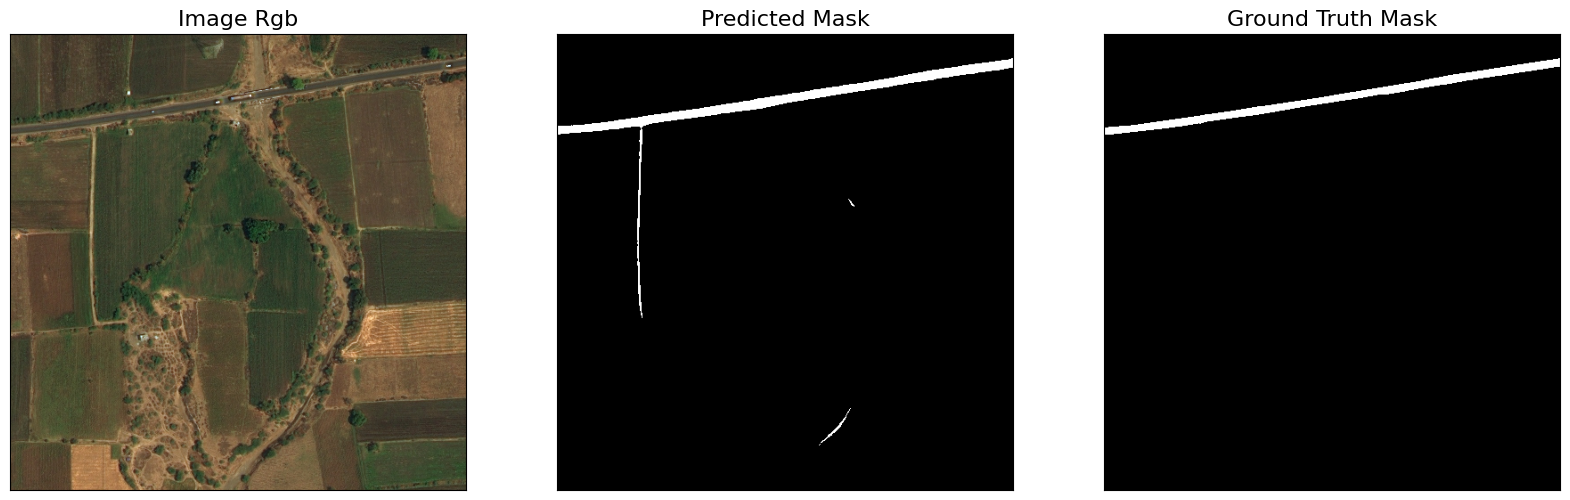

Image # 3


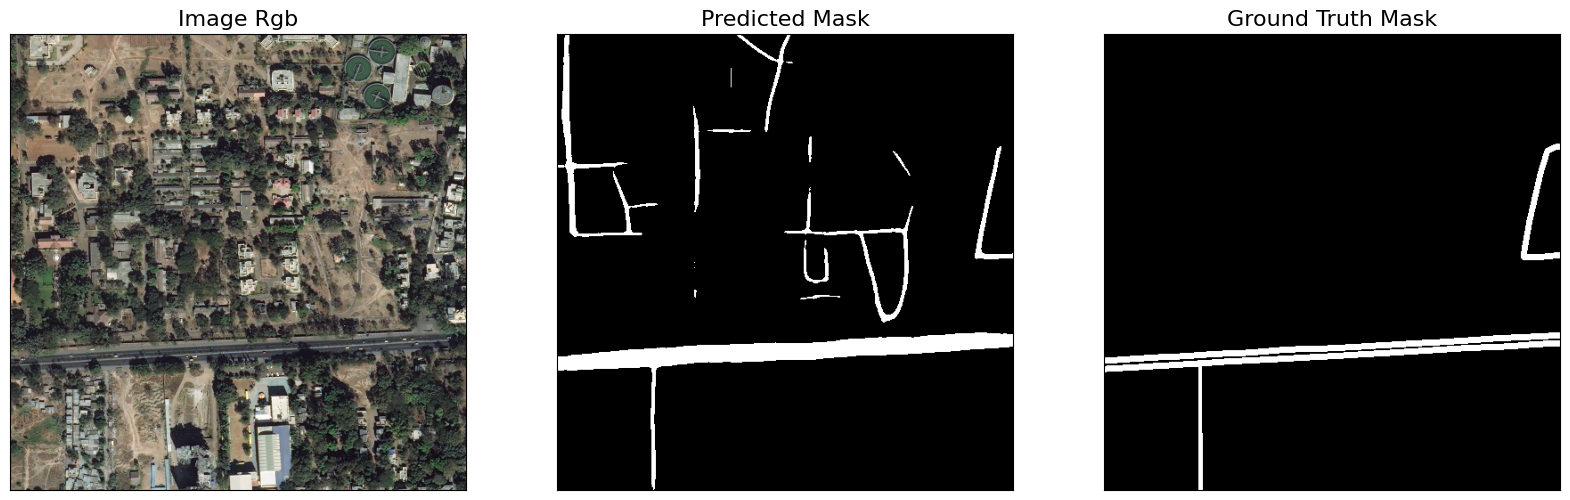

Image # 4


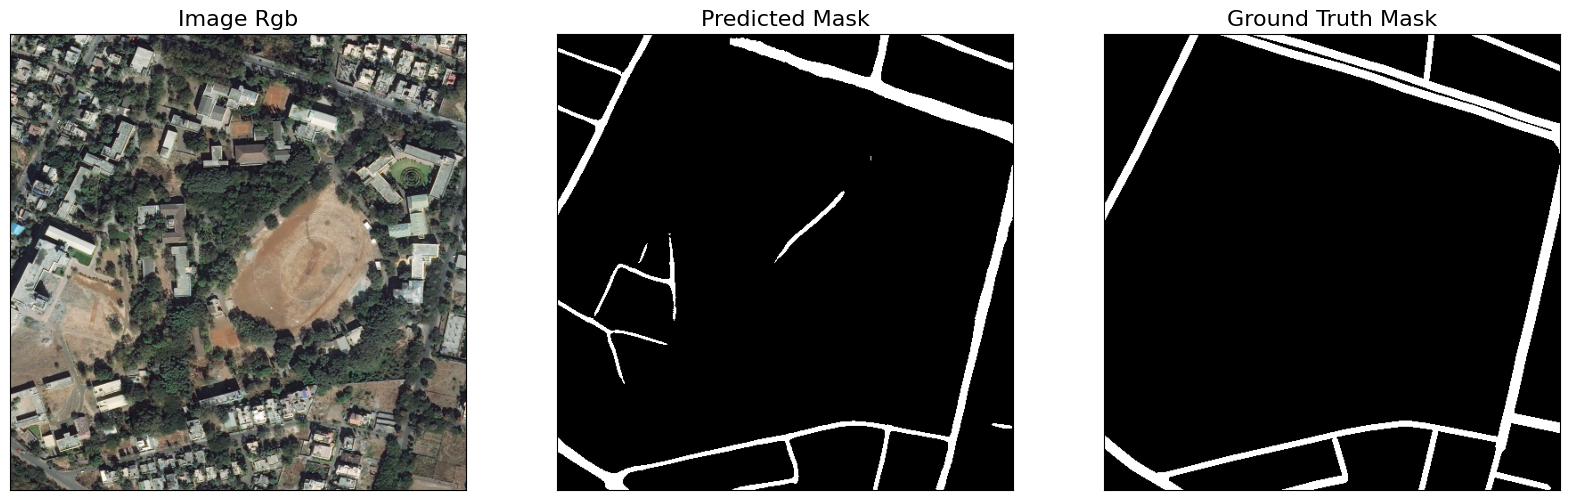

In [35]:
def visualize_predictions(
    model,
    dataset,
    start_idx=0,
    end_idx=5,
    device=DEVICE,
    threshold=0.5,  # Keep threshold to match training metrics
):
    """
    Optimized visualization for road segmentation with threshold matching training metrics.

    Args:
        model: Trained road segmentation model (output shape: (1,H,W))
        dataset: Test dataset
        start_idx/end_idx: Range to visualize
        device: Target device
        threshold: 0.5 to match IoU/Fscore metrics (critical for consistency)
    """
    model.eval()

    # Color codes - adjust based on your label convention
    BACKGROUND_COLOR = [0, 0, 0]    # Black
    ROAD_COLOR = [255, 255, 255]     # White

    with torch.no_grad():
        for i in range(start_idx, end_idx):
            print("Image # " + str(i))

            image, mask = dataset[i]

            image_tensor = image.unsqueeze(0).to(DEVICE)

            preds = model(image_tensor).squeeze(1) # Remove channel dim for (B,H,W)

            # Vectorized processing
            binary_masks = (preds > threshold).cpu().numpy()

            # Process mask
            mask_indices = reverse_one_hot(mask)
            ground_truth = colour_code_segmentation(mask_indices, select_class_rgb_values)

            for i, mask in enumerate(binary_masks):
                # Efficient color mapping
                colored_mask = np.empty((*mask.shape, 3), dtype=np.uint8)
                colored_mask[mask == 1] = ROAD_COLOR
                colored_mask[mask == 0] = BACKGROUND_COLOR

                visualize(
                    image_rgb=denormalize_image(image),
                    predicted_mask=colored_mask,
                    ground_truth_mask=ground_truth,
                )

visualize_predictions(best_model, valid_dataset)

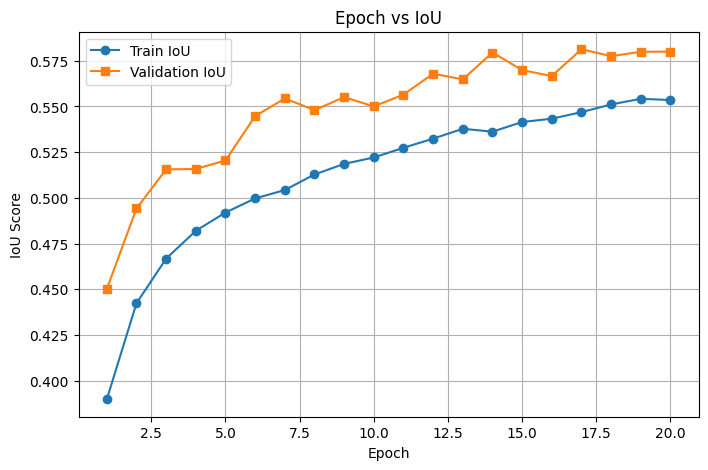

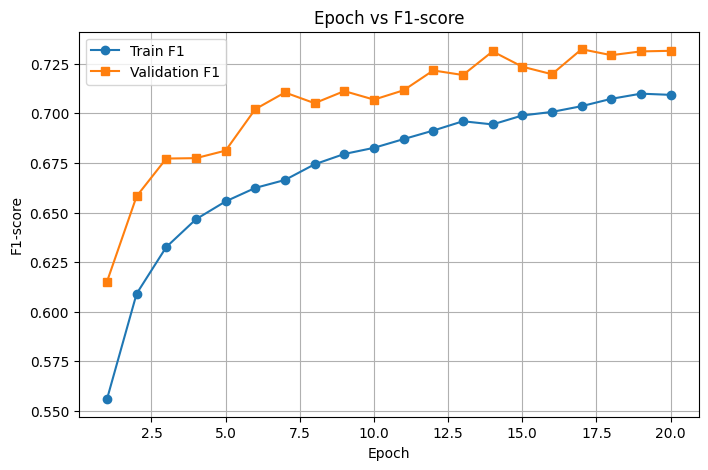

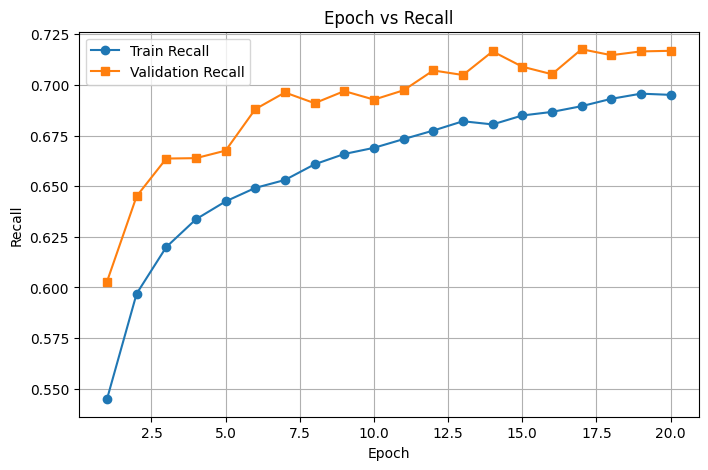

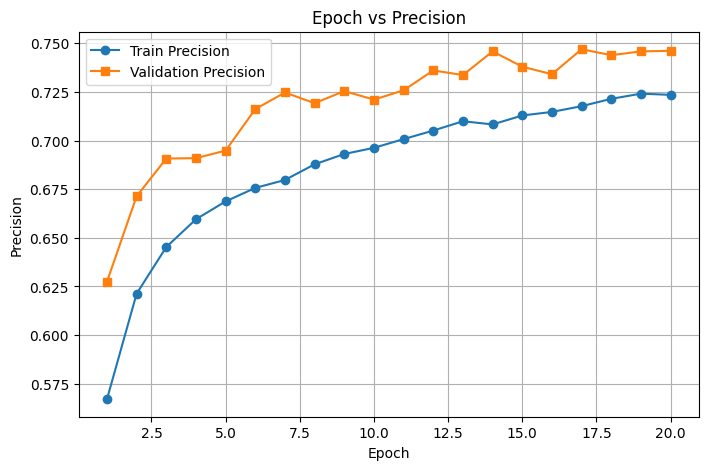

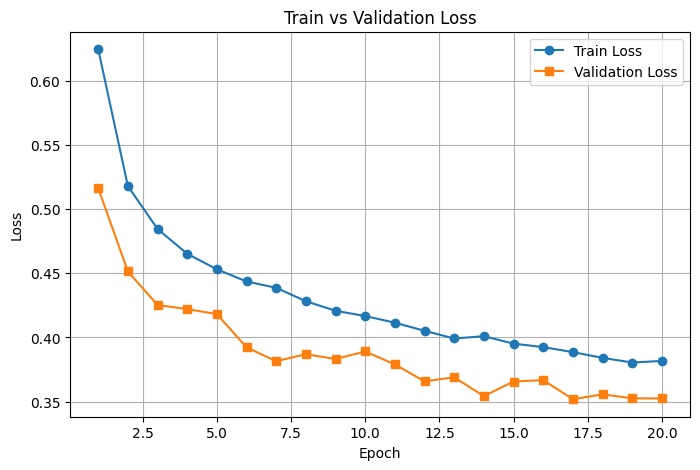

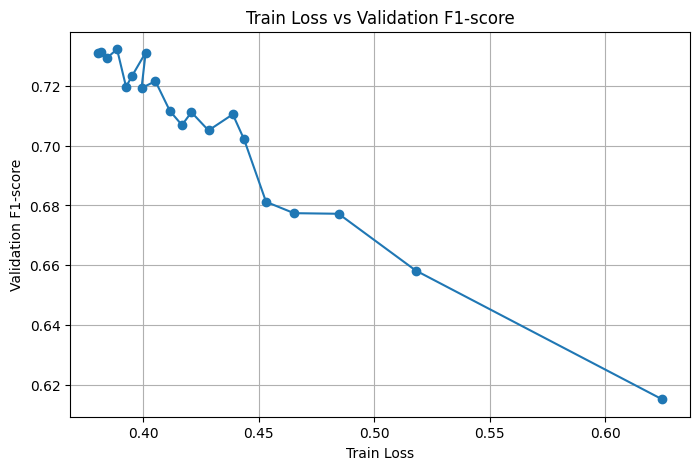

In [39]:
import matplotlib.pyplot as plt

# Example metric values (replace these lists with your actual logs)
epochs = list(range(1, 21))

train_iou = [0.3899, 0.4424, 0.4668, 0.4820, 0.4920, 0.4997, 0.5043, 0.5128, 0.5186, 0.5221, 0.5274, 0.5324, 0.5378, 0.5362, 0.5415, 0.5433, 0.5469, 0.5511, 0.5542, 0.5535]
val_iou   = [0.4502, 0.4942, 0.5156, 0.5158, 0.5205, 0.5447, 0.5544, 0.5480, 0.5551, 0.5500, 0.5565, 0.5679, 0.5648, 0.5795, 0.5699, 0.5666, 0.5813, 0.5775, 0.5799, 0.5800]

train_f1  = [0.5559, 0.6091, 0.6326, 0.6466, 0.6556, 0.6624, 0.6664, 0.6743, 0.6795, 0.6826, 0.6870, 0.6913, 0.6960, 0.6944, 0.6989, 0.7007, 0.7036, 0.7073, 0.7099, 0.7093]
val_f1    = [0.6151, 0.6582, 0.6772, 0.6774, 0.6812, 0.7021, 0.7105, 0.7051, 0.7112, 0.7069, 0.7116, 0.7216, 0.7193, 0.7312, 0.7235, 0.7197, 0.7323, 0.7293, 0.7312, 0.7315]

train_loss = [0.6245, 0.5179, 0.4845, 0.4652, 0.4531, 0.4436, 0.4387, 0.4282, 0.4208, 0.4167, 0.4115, 0.4052, 0.3992, 0.4010, 0.3952, 0.3925, 0.3886, 0.3841, 0.3805, 0.3817]
val_loss   = [0.5163, 0.4514, 0.4253, 0.4221, 0.4182, 0.3923, 0.3815, 0.3870, 0.3832, 0.3891, 0.3790, 0.3658, 0.3690, 0.3543, 0.3657, 0.3668, 0.3519, 0.3557, 0.3526, 0.3525]

# Placeholder recall and precision (if you logged them, replace with real data)
# Otherwise, these are optional metrics for plotting
train_recall = [val * 0.98 for val in train_f1]  # dummy example
val_recall = [val * 0.98 for val in val_f1]
train_precision = [val * 1.02 for val in train_f1]
val_precision = [val * 1.02 for val in val_f1]

# -------- Plot IoU --------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_iou, 'o-', label='Train IoU')
plt.plot(epochs, val_iou, 's-', label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.title('Epoch vs IoU')
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot F1-score --------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_f1, 'o-', label='Train F1')
plt.plot(epochs, val_f1, 's-', label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Epoch vs F1-score')
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot Recall --------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_recall, 'o-', label='Train Recall')
plt.plot(epochs, val_recall, 's-', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Epoch vs Recall')
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot Precision --------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_precision, 'o-', label='Train Precision')
plt.plot(epochs, val_precision, 's-', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Epoch vs Precision')
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot Loss Comparison --------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 's-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------- Train Loss vs Validation F1 --------
plt.figure(figsize=(8,5))
plt.plot(train_loss, val_f1, 'o-')
plt.xlabel('Train Loss')
plt.ylabel('Validation F1-score')
plt.title('Train Loss vs Validation F1-score')
plt.grid(True)
plt.show()
